In [2]:
from google.colab import drive
drive.mount("./drive")

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [3]:
!pip install livelossplot

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *

from livelossplot import PlotLossesKeras

from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.utils import class_weight

import cv2
from PIL import Image

import numpy as np
import scipy
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm, notebook

import warnings
warnings.filterwarnings('ignore')

from zipfile import ZipFile
print("All modules are successfull loaded")

All modules are successfull loaded


In [5]:
# with ZipFile("./drive/MyDrive/DockShip_Hiring_Challenge/attentive_ai_internship_hiring_challenge-dataset.zip") as file:
#     file.extractall()
# file.close()
# print("Extraction Done")

In [6]:
TRAIN_DATA = "./merged_data/train"
TEST_DATA = "./merged_data/test"
TRAIN_CSV = "./drive/MyDrive/DockShip_Hiring_Challenge/train_csv.csv"
TEST_CSV = "./drive/MyDrive/DockShip_Hiring_Challenge/test_csv.csv"
WORK_DIR = "./drive/MyDrive/DockShip_Hiring_Challenge/"

# Time to get our hands dirty

In [7]:
train_csv = pd.read_csv(TRAIN_CSV)
test_csv = pd.read_csv(TEST_CSV)

In [8]:
train_csv

,0,1,paths,img_shape
0,0.jpg,Adhered,./merged_data/train/0.jpg,"(3, 1063, 461)"
1,1.jpg,Adhered,./merged_data/train/1.jpg,"(3, 190, 282)"
2,2.jpg,Concrete,./merged_data/train/2.jpg,"(3, 80, 72)"
3,3.jpg,Concrete,./merged_data/train/3.jpg,"(3, 103, 73)"
4,4.jpg,Plastic & fabric,./merged_data/train/4.jpg,"(3, 150, 120)"
...,...,...,...,...
8639,8639.jpg,Adhered,./merged_data/train/8639.jpg,"(3, 1502, 1598)"
8640,8640.jpg,Adhered,./merged_data/train/8640.jpg,"(3, 1674, 358)"
8641,8641.jpg,Adhered,./merged_data/train/8641.jpg,"(3, 4070, 6005)"
8642,8642.jpg,Adhered,./merged_data/train/8642.jpg,"(3, 294, 493)"


In [9]:
test_csv

,0,1,paths,img_shape
0,0.jpg,Adhered,./merged_data/test/0.jpg,"(3, 609, 388)"
1,1.jpg,Adhered,./merged_data/test/1.jpg,"(3, 90, 43)"
2,2.jpg,Adhered,./merged_data/test/2.jpg,"(3, 211, 365)"
3,3.jpg,Adhered,./merged_data/test/3.jpg,"(3, 1818, 913)"
4,4.jpg,Adhered,./merged_data/test/4.jpg,"(3, 433, 105)"
...,...,...,...,...
591,591.jpg,Adhered,./merged_data/test/591.jpg,"(3, 4080, 3220)"
592,592.jpg,Adhered,./merged_data/test/592.jpg,"(3, 635, 682)"
593,593.jpg,Adhered,./merged_data/test/593.jpg,"(3, 117, 284)"
594,594.jpg,Adhered,./merged_data/test/594.jpg,"(3, 901, 720)"


# Augmenting data

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle = True)

for idx,(tr_,te_) in enumerate(skf.split(train_csv["paths"],y=train_csv["1"])):
    train_csv.loc[te_,'kfold']=idx

In [11]:
train_csv

,0,1,paths,img_shape,kfold
0,0.jpg,Adhered,./merged_data/train/0.jpg,"(3, 1063, 461)",0.0
1,1.jpg,Adhered,./merged_data/train/1.jpg,"(3, 190, 282)",4.0
2,2.jpg,Concrete,./merged_data/train/2.jpg,"(3, 80, 72)",3.0
3,3.jpg,Concrete,./merged_data/train/3.jpg,"(3, 103, 73)",4.0
4,4.jpg,Plastic & fabric,./merged_data/train/4.jpg,"(3, 150, 120)",2.0
...,...,...,...,...,...
8639,8639.jpg,Adhered,./merged_data/train/8639.jpg,"(3, 1502, 1598)",2.0
8640,8640.jpg,Adhered,./merged_data/train/8640.jpg,"(3, 1674, 358)",1.0
8641,8641.jpg,Adhered,./merged_data/train/8641.jpg,"(3, 4070, 6005)",4.0
8642,8642.jpg,Adhered,./merged_data/train/8642.jpg,"(3, 294, 493)",0.0


In [12]:
len(os.listdir("./merged_data/train"))

8644

In [38]:
def dataAugmentWithSkf(train_data, img_shape, preprocessing_function=None, batch_size = 64, img_dir = "/content/merged_data/train", x_col = "paths", y_col = "1"):

    train_data[y_col] = train_data[y_col].astype(str) 
    train_exmpls = train_data[train_data.kfold!=0]
    val_exmpls = train_data[train_data.kfold==0]
    # train_data[y_col] = train_data[y_col].astype('float32')

    trainGen = ImageDataGenerator(preprocessing_function = preprocessing_function,
                                  rotation_range = 270,
                                  zoom_range = 0.2,
                                #   cval = 0.,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                #   shear_range = 0.15,
                                  height_shift_range = 0.2,
                                  width_shift_range = 0.2,
                                  brightness_range = [0.2, 0.5],
                                  rescale = 1/255.,                       
                                )

    train_set = trainGen.flow_from_dataframe(train_exmpls,
                            directory = img_dir,
                            x_col = x_col,
                            y_col = y_col,
                            target_size = img_shape,
                            batch_size = batch_size,
                            )

    valGen = ImageDataGenerator(preprocessing_function = preprocessing_function,
                                rescale = 1/255.                                
                                )

    val_set = valGen.flow_from_dataframe(val_exmpls,
                            directory = img_dir,
                            x_col = x_col,
                            y_col = y_col,
                            target_size = img_shape,
                            batch_size = batch_size,
                            )
       
    return train_set, val_set
    
img_shape = [224, 224]
train_set, val_set = dataAugmentWithSkf(train_csv,
                                        img_shape,
                                        x_col = "0",
                                        y_col = '1',
                                        )

Found 6915 validated image filenames belonging to 6 classes.
Found 1729 validated image filenames belonging to 6 classes.


In [77]:
def traingen(train_data, img_shape, preprocessing_function=None, batch_size = 64, img_dir = "/content/merged_data/train", x_col = "paths", y_col = "1", n_models = 1):

    train_data[y_col] = train_data[y_col].astype(str) 
    train_exmpls = train_data[train_data.kfold!=0]
    val_exmpls = train_data[train_data.kfold==0]
    # train_data[y_col] = train_data[y_col].astype('float32')

    trainGen = ImageDataGenerator(preprocessing_function = preprocessing_function,
                                  rotation_range = 270,
                                  zoom_range = 0.2,
                                #   cval = 0.,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                #   shear_range = 0.15,
                                  height_shift_range = 0.2,
                                  width_shift_range = 0.2,
                                  brightness_range = [0.2, 0.5],
                                  rescale = 1/255.,                       
                                )

    train_set = trainGen.flow_from_dataframe(train_exmpls,
                            directory = img_dir,
                            x_col = x_col,
                            y_col = y_col,
                            target_size = img_shape,
                            batch_size = batch_size,
                            )
    while True:
        X = train_set.next()
        yield [X[0]]*n_models, X[1]
       
def valgen(train_data, img_shape, preprocessing_function=None, batch_size = 64, img_dir = "/content/merged_data/train", x_col = "paths", y_col = "1", n_models = 1):

    train_data[y_col] = train_data[y_col].astype(str) 
    train_exmpls = train_data[train_data.kfold!=0]
    val_exmpls = train_data[train_data.kfold==0]
    # train_data[y_col] = train_data[y_col].astype('float32')

    valGen = ImageDataGenerator(preprocessing_function = preprocessing_function,
                                rescale = 1/255.                                
                                )

    val_set = valGen.flow_from_dataframe(val_exmpls,
                            directory = img_dir,
                            x_col = x_col,
                            y_col = y_col,
                            target_size = img_shape,
                            batch_size = batch_size,
                            )
    while True:
        X = val_set.next()
        yield [X[0]]*n_models, X[1]
       
        

In [78]:
traingenerator = traingen(train_csv,
                        img_shape,
                        x_col = "0",
                        y_col = '1',)
valgenerator = valgen(train_csv,
                        img_shape,
                        x_col = "0",
                        y_col = '1',)

In [79]:
classes = {'Adhered': 0,
        'Ballasted': 1,
        'Concrete': 2,
        'Plastic & fabric': 3,
        'Shingle': 4,
        'Steel': 5}

In [80]:
len(next(val_set)[0])

64

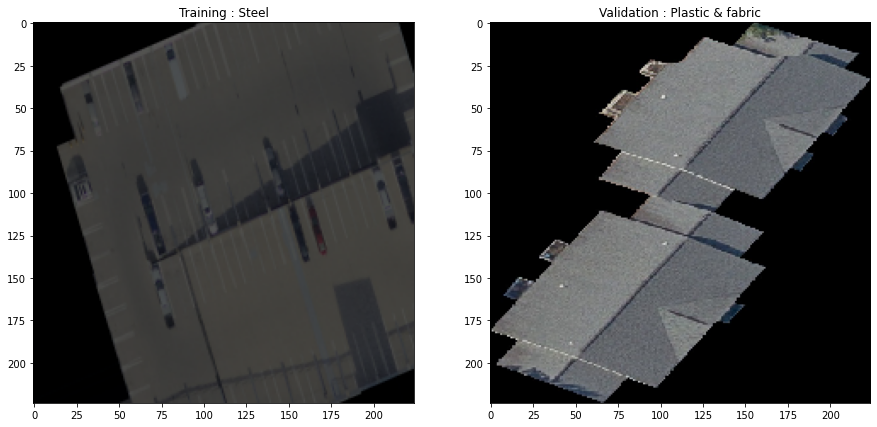

In [81]:
idx = np.random.randint(len(next(val_set)[0]))
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
plt.imshow((next(train_set)[0][idx]));
plt.title(f"Training : {list(classes.keys())[list(next(train_set)[-1][idx]).index(1)]}")

plt.subplot(1, 2, 2)
plt.imshow((next(val_set)[0][idx]));
plt.title(f"Validation : {list(classes.keys())[list(next(val_set)[-1][idx]).index(1)]}")
plt.show();

# Building a model

In [82]:
i = 0
for wt_file in os.listdir(WORK_DIR):
    if(wt_file.endswith('h5')):
        i+=1
        print(i, wt_file)

1 ResNet50_52.h5
2 EffNetB0_67.09080338478088.h5
3 ResNet50_35.62752902507782.h5
4 resnet50v2_83.1116259098053.h5
5 inception_resnet_v2_83.74783396720886.h5
6 inception_resnet_v2_84.h5
7 inception_resnet_v2_acc_84.h5
8 xception_85.h5
9 xception_acc_85.h5
10 inception_v3_84.h5
11 densenet201_84.h5
12 inception_v3_extended_89.h5
13 xception_extended_89.h5


In [83]:
# model_weights = ['inception_v3_extended_89.h5',
#                  'xception_extended_89.h5',
#                  'xception_85.h5',
#                  'inception_v3_84.h5',
#                  'inception_resnet_v2_84.h5'
#                  ]
# models = []
# for model_weight in tqdm(model_weights):
#     model = load_model(os.path.join(WORK_DIR, model_weight))
#     models.append(model)

In [84]:
n_models = len(models)
n_models

5

# Using simple Blending Method

In [85]:
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
            layer._name = f"ensemble_{i+1}_{layer.name}"

    ensemble_inputs = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]
    
    merge = concatenate(ensemble_outputs)
    output = Dense(5, activation = 'softmax')(merge)
    
    model = Model(inputs = ensemble_inputs, outputs = output, name = "simpleBlending")    
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy', 'AUC']
                 )
    return model


sbmodel = define_stacked_model(models)

In [86]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, 
                              verbose=1, mode='min', min_lr = 1e-7)

model_Best_save = ModelCheckpoint(f"/content/ModelCheckpoints/{sbmodel.name}.h5",
                                                    monitor = "val_auc",
                                                    save_weights = True,
                                                    save_best_only = True,
                                                    mode = "min"
                                                    )
LR = 1e-3

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes = list(classes.keys()), y = train_csv['1'].values)

sbmodel.compile(loss = 'categorical_crossentropy',
              loss_weights= class_weights,
              metrics = ['accuracy', 'AUC'],
              optimizer = Adam(lr = LR)
              )

callbacks = [model_Best_save, early_stop, reduce_lr]

In [ ]:
model.fit(traingenerator,
        verbose = 1,
        use_multiprocessing = True,
        epochs = n_epoch,
        validation_data = valgenerator)

Found 6915 validated image filenames belonging to 6 classes.
Epoch 1/10
    154/Unknown - 266s 2s/step - loss: 0.3649 - accuracy: 0.8698 - auc: 0.9850

In [ ]:
# def preprocess_img(img_path):
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))
#     img = img/255.
    
#     return img


# x_train = []; x_val = []
# y_train = []; y_val = []

# train_exmpls = train_csv[train_csv.kfold!=0]
# val_exmpls = train_csv[train_csv.kfold==0]

# train_paths = train_exmpls.paths.values
# train_labels = train_exmpls['1'].values

# val_paths = val_exmpls.paths.values
# val_labels = val_exmpls['1'].values

# for i in tqdm(range(len(train_paths))):
#     tmp = preprocess_img(train_paths[i])
#     x_train.append(tmp)
#     y_train.append(classes[train_labels[i]])

# for i in tqdm(range(len(val_paths))):
#     tmp = preprocess_img(val_paths[i])
#     x_val.append(tmp)
#     y_val.append(classes[val_labels[i]])

# x_train = np.array(x_train); x_val = np.array(x_val)
# y_train = np.array(y_train); y_val = np.array(y_val)

# print(f"x_train.shape : {x_train.shape}")
# print(f"y_train.shape : {y_train.shape}")

# print(f"x_val.shape : {x_val.shape}")
# print(f"y_val.shape : {y_val.shape}")

100%|██████████| 1729/1729 [00:23<00:00, 73.52it/s]


In [ ]:
train_exmpls[0]

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ensemble_5_ensemble_5_input_5 ( [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
ensemble_5_ensemble_5_conv2d (C (None, 111, 111, 32) 864         ensemble_5_ensemble_5_input_5[0][
__________________________________________________________________________________________________
ensemble_5_ensemble_5_batch_nor (None, 111, 111, 32) 96          ensemble_5_ensemble_5_conv2d[0][0
__________________________________________________________________________________________________
ensemble_5_ensemble_5_activatio (None, 111, 111, 32) 0           ensemble_5_ensemble_5_batch_norma
____________________________________________________________________________________________

# Performing a submission


In [ ]:
os.listdir(WORK_DIR)

['attentive_ai_internship_hiring_challenge-dataset.zip',
 'sample_imgs.png',
 'effb0_avg_pretrained.png',
 'train_csv.csv',
 'test_csv.csv',
 'ResNet50_notTrained.png',
 'ResNet50_52.h5',
 'EffNet0_notTrained.png',
 'EffNetB0_training_history.png',
 'EffNetB0_67.09080338478088.h5',
 'EffNet0_preTrained.png',
 'ResNet50_preTrained.png',
 'ResNet50',
 'ResNet50_35.62752902507782.h5',
 'ResNet50_training_history.png',
 'ResNet50.png',
 'resnet50v2.png',
 'Transfer Learning for Optical Satellite Images.pdf',
 'resnet50v2_training_history.png',
 'resnet50v2_83.1116259098053.h5',
 'efficientnetb4.png',
 'inception_resnet_v2.png',
 'inception_resnet_v2_83.74783396720886.h5',
 'inception_resnet_v2_84.h5',
 'inception_resnet_v2_training_history.png',
 'inception_resnet_v2_acc_84.h5',
 'xception.png',
 'xception_training_history.png',
 'xception_85.h5',
 'xception_acc_85.h5',
 'inception_v3.png',
 'inception_v3_training_history.png',
 'inception_v3_84.h5',
 'densenet201.png',
 'densenet201_train

In [ ]:
!ls ./ModelCheckpoints

inception_v3_extended.h5  xception_extended.h5


In [ ]:
sub_model = load_model(os.path.join(WORK_DIR, 'xception_extended_89.h5'))
# sub_model = load_model("/content/ModelCheckpoints/inception_v3_extended.h5")
# sub_model = model
sub_model.evaluate(val_set)

28/28 [==============================] - 22s 729ms/step - loss: 0.3164 - accuracy: 0.8890 - auc: 0.9880


[0.31639477610588074, 0.8889531493186951, 0.9879971742630005]

In [ ]:
# !cp ./ModelCheckpoints/inception_v3.h5 ./drive/MyDrive/DockShip_Hiring_Challenge/

In [ ]:
sub_model.summary()

Model: "xception_extended"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________

In [ ]:
# test_imgs = []; train_imgs = []
# for img_path in tqdm(test_csv.paths):
#     img = cv2.imread(img_path)
#     img=  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))
#     img = img/255.
#     test_imgs.append(img)

# for img_path in tqdm(train_csv.iloc[:len(test_csv), :].paths):
#     img = cv2.imread(img_path)
#     img=  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))
#     img = img/255.
#     train_imgs.append(img)

# test_imgs = np.array(test_imgs)
# train_imgs = np.array(train_imgs)

In [ ]:
test_imgs.shape, train_imgs.shape

((596, 224, 224, 3), (596, 224, 224, 3))

In [ ]:
def giveMeClass(x):
    for key, val in classes.items():
        if val == x:
            return key
    return -1

test_preds = sub_model.predict(test_imgs)
train_preds = sub_model.predict(train_imgs)
tpreds = []
trpreds = []
for test_pred in tqdm(test_preds):
    tpreds.append(np.argmax(test_pred))

for train_pred in tqdm(train_preds):
    trpreds.append(np.argmax(train_pred))

train_check = train_csv.iloc[:len(test_csv), :]

train_check['Model_preds'] = trpreds
train_check['Model_preds'] = train_check['Model_preds'].apply(lambda x: giveMeClass(x))

test_csv['Model_preds'] = tpreds
test_csv['Model_preds'] = test_csv['Model_preds'].apply(lambda x: giveMeClass(x))

100%|██████████| 596/596 [00:00<00:00, 177454.76it/s]


In [ ]:
train_check

,0,1,paths,img_shape,kfold,Model_preds
0,0.jpg,Adhered,./merged_data/train/0.jpg,"(3, 1063, 461)",2.0,Adhered
1,1.jpg,Adhered,./merged_data/train/1.jpg,"(3, 190, 282)",4.0,Adhered
2,2.jpg,Concrete,./merged_data/train/2.jpg,"(3, 80, 72)",3.0,Concrete
3,3.jpg,Concrete,./merged_data/train/3.jpg,"(3, 103, 73)",3.0,Concrete
4,4.jpg,Plastic & fabric,./merged_data/train/4.jpg,"(3, 150, 120)",1.0,Plastic & fabric
...,...,...,...,...,...,...
591,591.jpg,Steel,./merged_data/train/591.jpg,"(3, 112, 127)",4.0,Steel
592,592.jpg,Plastic & fabric,./merged_data/train/592.jpg,"(3, 556, 666)",2.0,Plastic & fabric
593,593.jpg,Plastic & fabric,./merged_data/train/593.jpg,"(3, 719, 119)",3.0,Plastic & fabric
594,594.jpg,Plastic & fabric,./merged_data/train/594.jpg,"(3, 196, 166)",0.0,Plastic & fabric


In [ ]:
test_csv

,0,1,paths,img_shape,Model_preds
0,0.jpg,Adhered,./merged_data/test/0.jpg,"(3, 609, 388)",Ballasted
1,1.jpg,Adhered,./merged_data/test/1.jpg,"(3, 90, 43)",Steel
2,2.jpg,Adhered,./merged_data/test/2.jpg,"(3, 211, 365)",Ballasted
3,3.jpg,Adhered,./merged_data/test/3.jpg,"(3, 1818, 913)",Concrete
4,4.jpg,Adhered,./merged_data/test/4.jpg,"(3, 433, 105)",Steel
...,...,...,...,...,...
591,591.jpg,Adhered,./merged_data/test/591.jpg,"(3, 4080, 3220)",Plastic & fabric
592,592.jpg,Adhered,./merged_data/test/592.jpg,"(3, 635, 682)",Steel
593,593.jpg,Adhered,./merged_data/test/593.jpg,"(3, 117, 284)",Plastic & fabric
594,594.jpg,Adhered,./merged_data/test/594.jpg,"(3, 901, 720)",Ballasted


In [ ]:
print(classification_report(test_csv['1'], test_csv['Model_preds']))

                  precision    recall  f1-score   support

         Adhered       1.00      0.17      0.29       596
       Ballasted       0.00      0.00      0.00         0
        Concrete       0.00      0.00      0.00         0
Plastic & fabric       0.00      0.00      0.00         0
         Shingle       0.00      0.00      0.00         0
           Steel       0.00      0.00      0.00         0

        accuracy                           0.17       596
       macro avg       0.17      0.03      0.05       596
    weighted avg       1.00      0.17      0.29       596



In [ ]:
print(classification_report(train_check['1'], train_check['Model_preds']))

                  precision    recall  f1-score   support

         Adhered       0.93      0.88      0.90       366
       Ballasted       0.59      0.84      0.70        19
        Concrete       0.84      0.75      0.80        65
Plastic & fabric       0.94      0.84      0.89        57
         Shingle       1.00      0.89      0.94        35
           Steel       0.60      0.93      0.73        54

        accuracy                           0.87       596
       macro avg       0.82      0.85      0.83       596
    weighted avg       0.89      0.87      0.87       596



In [ ]:
submission = test_csv[['0', 'Model_preds']]
submission.rename({'Model_preds': "1"}, axis = 1, inplace = True)
submission.to_csv('output.csv', index = False)
submission

,0,1
0,0.jpg,Ballasted
1,1.jpg,Steel
2,2.jpg,Ballasted
3,3.jpg,Concrete
4,4.jpg,Steel
...,...,...
591,591.jpg,Plastic & fabric
592,592.jpg,Steel
593,593.jpg,Plastic & fabric
594,594.jpg,Ballasted
